# Generating Data

In [2]:
from google.colab import drive
drive.mount("/content/drive")
import numpy as np
import sklearn as skl

features=["fixed acidity"
  ,"volatile acidity"
  , "citric acid"
  ,"residual sugar" 
  ,"chlorides"
  ,"free sulfur dioxide"
  ,"total sulfur dioxide"
  ,"density"
  ,"pH"
  ,"sulphates"
  ,"alcohol"]

train=np.loadtxt("/content/drive/MyDrive/Colab Notebooks/amath 582 lecture notes/reports /3/wine_training.csv",delimiter=",")
test=np.loadtxt("/content/drive/MyDrive/Colab Notebooks/amath 582 lecture notes/reports /3/wine_test.csv",delimiter=",")

Mounted at /content/drive


# Normalization

In [3]:
train_N=train.shape[0]
test_N=test.shape[0]

# calculate the mean of each column
train_mean=np.mean(train,axis=0)
train_std=np.std(train,axis=0)

# calculate the standard deviation of each column
test_mean=np.mean(test,axis=0)
test_std=np.std(test,axis=0)

# normalize the train and test dataset based on the mean and std calculated
# the resulting normal dataset has 0 means and 1 std for each column
import numpy.matlib
train_normal=(train-np.matlib.repmat(train_mean,train_N,1))/np.matlib.repmat(train_std,train_N,1)
test_normal=(test-np.matlib.repmat(test_mean,test_N,1))/np.matlib.repmat(test_std,test_N,1)

# X for the 11-input features, Y for the quality output feature
X_train=train_normal[:,:-1]
Y_train=train_normal[:,-1]

X_test=test_normal[:,:-1]
Y_test=test_normal[:,-1]

# Task 1 
>Linear Regression Method

In [4]:
# Linear Regression fit
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(X_train,Y_train)

# calculating the train and tesr MSE
b=np.insert(reg.coef_,0,reg.intercept_)

MSE_train=1/len(Y_train)*np.linalg.norm(np.dot(X_train,b[1:])+b[0]-Y_train)**2
MSE_test=1/len(Y_test)*np.linalg.norm(np.dot(X_test,b[1:])+b[0]-Y_test)**2

print(f"The linear regression model has the train MSE {MSE_train} and the test MSE {MSE_test}, respectively")

The linear regression model has the train MSE 0.6278484956554817 and the test MSE 0.7021527395264008, respectively


# Task 2
>Gaussain (RBF) kernel

## First, we want to find a suitable range for $\sigma$ and $\lambda$. 1000 instances and 10 CVs take a lot of computation, so we focus on a 100 randomly chosen sample subset. 


In [5]:
# randomly select a subset of 100 rows from training data, with seed 1 for reproducible results
rng=np.random.default_rng(seed=1)
rand_100_train= rng.choice(train_normal,size=100,replace=False)

rand_X = rand_100_train[:,:-1]
rand_Y = rand_100_train[:,-1]

In [ ]:
# generate 20 different data points for both sigma and lambda
K_sigma=20
K_lambda=20

sgm=np.linspace(-5,5,K_sigma)
lmbd=np.linspace(-5,5,K_lambda)

# create scores and standard deviation of scores for gaussian kernel with different parameters sigma and lambda
score_rbf=np.zeros((K_sigma,K_lambda))
score_std_rbf=np.zeros((K_sigma,K_lambda))

import sklearn.kernel_ridge 
KRR_CV_rbf=sklearn.kernel_ridge.KernelRidge(kernel='rbf')

# looping over sigmas and lambdas, store the corresponding cross_validation score and score_std
# this time we use 100 randomly selected instances to get a rough range of parameters
for i in range(K_sigma):

  KRR_CV_rbf.gamma=1/(2*(2**sgm[i])**2)

  for j in range(K_lambda):

    KRR_CV_rbf.alpha=2**lmbd[j]

    this_score_rbf=skl.model_selection.cross_val_score(KRR_CV_rbf,rand_X,rand_Y,scoring="neg_mean_squared_error",cv=10)

    score_rbf[i,j]=np.mean(this_score_rbf)

    score_std_rbf[i,j]=np.std(this_score_rbf)


In [ ]:
print(score_rbf.max())

# find where the score has max value, which corresponds to min MSE
# same for score std
ij_min_rbf=np.where(score_rbf==score_rbf.max())
ij_min_std_rbf=np.where(score_std_rbf==score_std_rbf.min())


print('For Gaussian kernel, min MSE happens at ','log2 sigma= ', *sgm[ij_min_rbf[0]], 'log2 lambda: ',*lmbd[ij_min_rbf[1]])
print('For Gaussian kernel, min MSE std happens at , ','log2 sigma: ', *sgm[ij_min_std_rbf[0]], 'log2 lambda: ',*lmbd[ij_min_std_rbf[1]])



-0.8310143604675698
For Gaussian kernel, min MSE happens at  log2 sigma=  2.3684210526315788 log2 lambda:  -0.2631578947368425
For Gaussian kernel, min MSE std happens at ,  log2 sigma:  2.3684210526315788 log2 lambda:  -0.7894736842105265


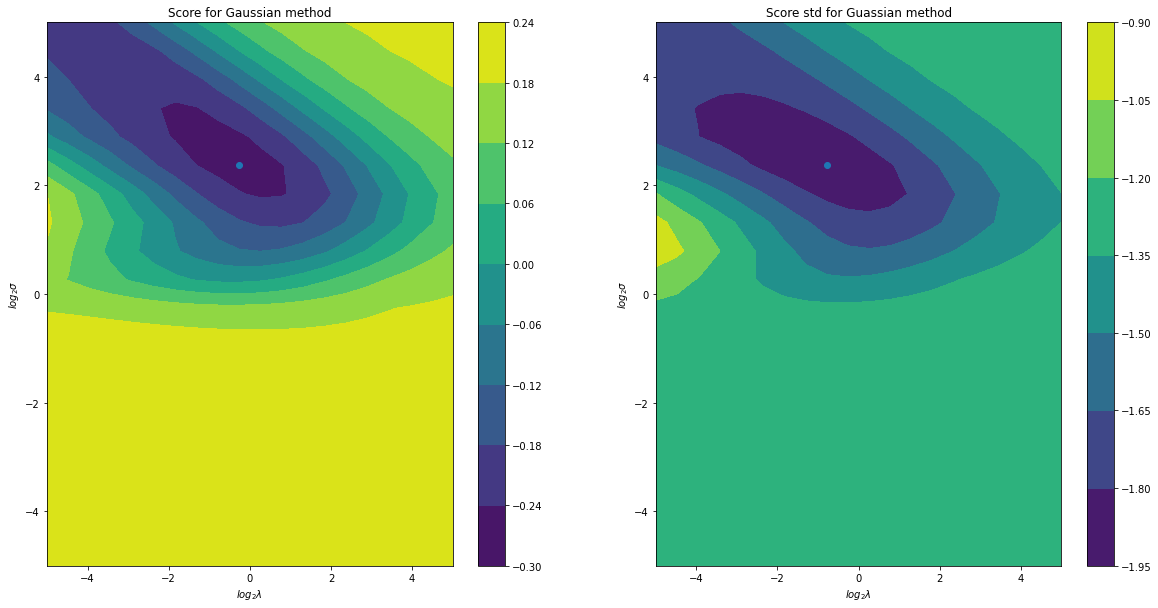

In [ ]:
# plot the contour map for score and score std with respect to log_2sigma, log_2lambda
import matplotlib.pyplot as plt

lv,sv=np.meshgrid(lmbd,sgm)

fig, ax = plt.subplots(1,2, figsize=(20,10))

cm0 = ax[0].contourf(lv,sv, np.log2(np.abs(score_rbf)))
ax[0].scatter(-0.263,2.368)
ax[0].set_xlabel('$log_2\lambda$')
ax[0].set_ylabel('$log_2\sigma$')
ax[0].set_title('Score for Gaussian method')
fig.colorbar(cm0, ax=ax[0])


cm1 = ax[1].contourf(lv, sv, np.log2(np.abs(score_std_rbf)))
ax[1].scatter(-0.789,2.368)
ax[1].set_xlabel('$log_2\lambda$')
ax[1].set_ylabel('$log_2\sigma$')
ax[1].set_title('Score std for Guassian method')
fig.colorbar(cm1, ax=ax[1])



From the two graphs above, we see that a reasonable choice for Gaussian kernel's parameters $\sigma$ and $\lambda$ in the $log_2$ form is abouot $log_2\sigma \in (1.5,4), \;log_2\lambda \in (-3,1)$

We now use the whole train dataset to tune around the optimal parameters we found.

In [23]:
# generate 20 different data points for both sigma and lambda
K_sigma=20
K_lambda=20

sgm=np.linspace(1.5,4,K_sigma) # in the range of 1.5 to 4
lmbd=np.linspace(-3,1,K_lambda) # in the range of -3 to 1

# create scores and standard deviation of scores for gaussian kernel with different parameters sigma and lambda
score_rbf=np.zeros((K_sigma,K_lambda))
score_std_rbf=np.zeros((K_sigma,K_lambda))

import sklearn.kernel_ridge 

KRR_CV_rbf=sklearn.kernel_ridge.KernelRidge(kernel='rbf')

# looping over sigmas and lambdas, store the corresponding cross_validation score and score_std
for i in range(K_sigma):
  KRR_CV_rbf.gamma=1/(2*(2**sgm[i])**2)
  for j in range(K_lambda):

    KRR_CV_rbf.alpha=(2**lmbd[j])

    this_score_rbf=skl.model_selection.cross_val_score(KRR_CV_rbf,X_train,Y_train,scoring="neg_mean_squared_error",cv=10)

    score_rbf[i,j]= (np.mean(this_score_rbf))

    score_std_rbf[i,j]=(np.std(this_score_rbf))

In [24]:
print(score_rbf.max())

# get where we have the min score and min score std
ij_min_rbf=np.where(score_rbf==score_rbf.max())
ij_min_std_rbf=np.where(score_std_rbf==score_std_rbf.min())

print('For Gaussian kernel, min MSE happens at ','log2 sigma: ', *sgm[ij_min_rbf[0]], 'log2 lambda: ',*lmbd[ij_min_rbf[1]])
print('For Gaussian kernel min MSE std happens at , ','log2 sigma: ', *sgm[ij_min_std_rbf[0]], 'log2 lambda: ',*lmbd[ij_min_std_rbf[1]])


-0.5957192976653385
For Gaussian kernel, min MSE happens at  log2 sigma:  2.026315789473684 log2 lambda:  -2.7894736842105265
For Gaussian kernel min MSE std happens at ,  log2 sigma:  1.763157894736842 log2 lambda:  -1.5263157894736843


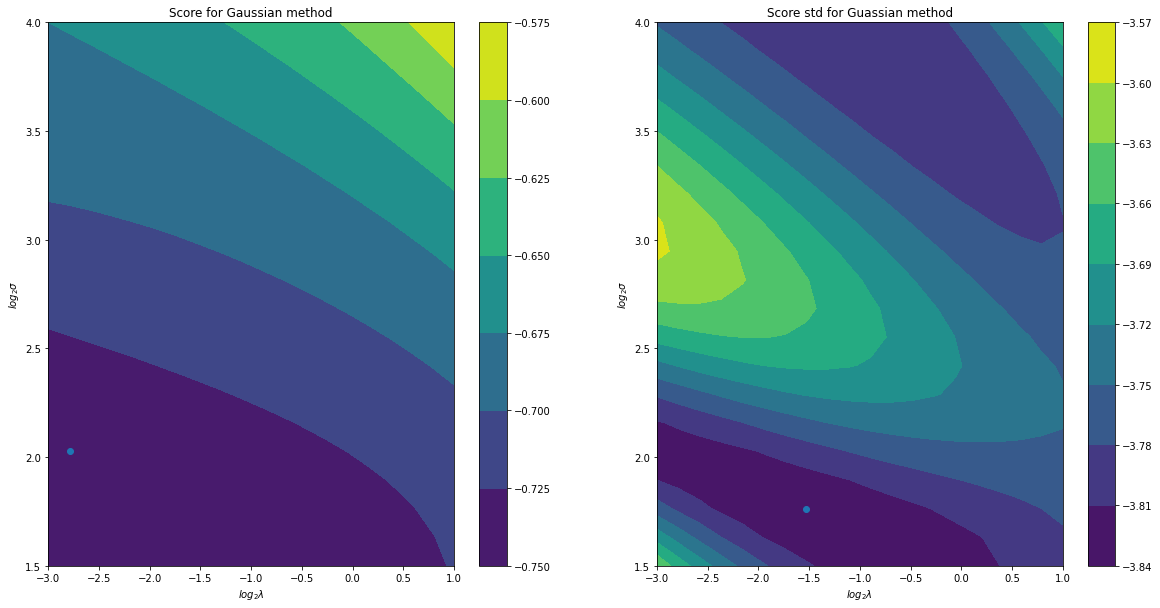

In [26]:
# plot the contour map
import matplotlib.pyplot as plt
lv1,sv1=np.meshgrid(lmbd,sgm)

fig,ax=plt.subplots(1,2,figsize=(20,10))

cm0 = ax[0].contourf(lv1,sv1, np.log2(np.abs(score_rbf)))
ax[0].scatter(-2.789,2.026)
ax[0].set_xlabel('$log_2\lambda$')
ax[0].set_ylabel('$log_2\sigma$')
ax[0].set_title('Score for Gaussian method')
fig.colorbar(cm0, ax=ax[0])

cm1 = ax[1].contourf(lv1, sv1, np.log2(np.abs(score_std_rbf)))
ax[1].scatter(-1.53,1.763)
ax[1].set_xlabel('$log_2\lambda$')
ax[1].set_ylabel('$log_2\sigma$')
ax[1].set_title('Score std for Guassian method')
fig.colorbar(cm1, ax=ax[1])

We then choose $\sigma = 2^{2.026}$, and $\lambda = 2^{-2.789}$ to obtain the best fit. 

Moving on to find the true train and test MSEs:

In [28]:
KRR_CV_rbf=sklearn.kernel_ridge.KernelRidge(kernel='rbf')
KRR_CV_rbf.gamma=1/(2*(2**2.026)**2)
KRR_CV_rbf.alpha=2**-2.789
KRR_CV_rbf.fit(X_train,Y_train)

p2_train=KRR_CV_rbf.predict(X_train)
p2_test=KRR_CV_rbf.predict(X_test)

mse_train=1/len(p2_train)*np.linalg.norm(p2_train-Y_train)**2
mse_test=1/len(p2_test)*np.linalg.norm(p2_test-Y_test)**2

print(f'The train MSE for Gaussian kernel is found to be {mse_train}, and the test MSE being {mse_test}')

The train MSE for Gaussian kernel is found to be 0.46042463422549734, and the test MSE being 0.6486391952783674


# Laplacian Method

In [15]:
# generate 20 different data points for both sigma and lambda
K_sigma=20
K_lambda=20

sgm=np.linspace(-5,5,K_sigma)
lmbd=np.linspace(-5,5,K_lambda)

# create scores and standard deviation of scores for laplacian kernel with different parameters sigma and lambda
score_lap=np.zeros((K_sigma,K_lambda))
score_std_lap=np.zeros((K_sigma,K_lambda))

import sklearn.kernel_ridge 
KRR_CV_lap=sklearn.kernel_ridge.KernelRidge(kernel='laplacian')

# looping over sigmas and lambdas, store the corresponding cross_validation score and score_std
# this time we use 100 randomly selected instances to get a rough range of parameters
for i in range(K_sigma):

  KRR_CV_lap.gamma=1/(2**sgm[i])

  for j in range(K_lambda):

    KRR_CV_lap.alpha=2**lmbd[j]

    this_score_lap=skl.model_selection.cross_val_score(KRR_CV_lap,rand_X,rand_Y,scoring="neg_mean_squared_error",cv=10)

    score_lap[i,j]=np.mean(this_score_lap)

    score_std_lap[i,j]=np.std(this_score_lap)



In [16]:
print(score_lap.max())

ij_min_lap=np.where(score_lap==score_lap.max())
ij_min_std_lap=np.where(score_std_lap==score_std_lap.min())


print('For Laplacian kernel, min MSE happens at ','log2 sigma: ', *sgm[ij_min_lap[0]], 'log2 lambda: ',*lmbd[ij_min_lap[1]])
print('For Laplacian kernel, min MSE std happens at , ','log2 sigma: ', *sgm[ij_min_std_lap[0]], 'log2 lambda: ',*lmbd[ij_min_std_lap[1]])

-0.8260579472779549
For Laplacian kernel, min MSE happens at  log2 sigma:  5.0 log2 lambda:  -1.3157894736842106
For Laplacian kernel, min MSE std happens at ,  log2 sigma:  5.0 log2 lambda:  -1.8421052631578947


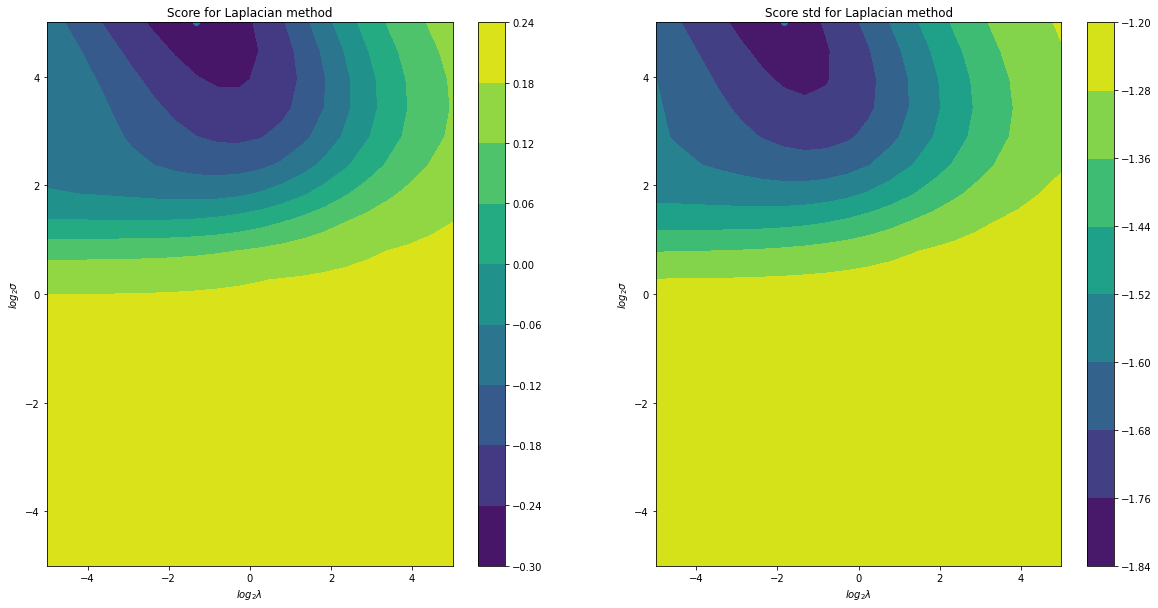

In [17]:
import matplotlib.pyplot as plt
lv2,sv2=np.meshgrid(lmbd,sgm)

fig, ax = plt.subplots(1,2, figsize=(20,10))

cm0 = ax[0].contourf(lv2,sv2, np.log2(np.abs(score_lap)))
ax[0].scatter(-1.316,5.0)
ax[0].set_xlabel('$log_2\lambda$')
ax[0].set_ylabel('$log_2\sigma$')
ax[0].set_title('Score for Laplacian method')
fig.colorbar(cm0, ax=ax[0])


cm1 = ax[1].contourf(lv2, sv2, np.log2(np.abs(score_std_lap)))
ax[1].scatter(-1.842,5.0)
ax[1].set_xlabel('$log_2\lambda$')
ax[1].set_ylabel('$log_2\sigma$')
ax[1].set_title('Score std for Laplacian method')
fig.colorbar(cm1, ax=ax[1])

From the two graphs above, we see that a reasonable choice for Gaussian kernel's parameters $\sigma$ and $\lambda$ in the $log_2$ form is about linearly related. Here we make a choice for range of $\sigma$ being $log_2\sigma \in (0,8)$ and for range of $\lambda$ being $log_2\lambda\in(-4,-1).$


We now use the whole train dataset to tune around the optimal parameters we found.

In [18]:
# generate 20 different data points for both sigma and lambda
K_sigma=20
K_lambda=20

sgm=np.linspace(0,8,K_sigma)
lmbd=np.linspace(-4,-1,K_lambda)

# create scores and standard deviation of scores for laplacian kernel with different parameters sigma and lambda
score_lap=np.zeros((K_sigma,K_lambda))
score_std_lap=np.zeros((K_sigma,K_lambda))

import sklearn.kernel_ridge 

KRR_CV_lap=sklearn.kernel_ridge.KernelRidge(kernel='laplacian')

# looping over sigmas and lambdas, store the corresponding cross_validation score and score_std
for i in range(K_sigma):

  KRR_CV_lap.gamma=1/(2**sgm[i])

  for j in range(K_lambda):

    KRR_CV_lap.alpha=2**lmbd[j]

    this_score_lap=skl.model_selection.cross_val_score(KRR_CV_lap,X_train,Y_train,scoring="neg_mean_squared_error",cv=10)

    score_lap[i,j]=np.mean(this_score_lap)

    score_std_lap[i,j]=np.std(this_score_lap)



In [19]:
print(score_lap.max())

ij_min_lap=np.where(score_lap==score_lap.max())
ij_min_std_lap=np.where(score_std_lap==score_std_lap.min())

print('Min MSE happens at ','log2 sigma: ', *sgm[ij_min_lap[0]], 'log2 lambda: ',*lmbd[ij_min_lap[1]])
print('Min MSE std happens at , ','log2 sigma: ', *sgm[ij_min_std_lap[0]], 'log2 lambda: ',*lmbd[ij_min_std_lap[1]])


-0.5450823381429087
Min MSE happens at  log2 sigma:  2.1052631578947367 log2 lambda:  -2.105263157894737
Min MSE std happens at ,  log2 sigma:  4.631578947368421 log2 lambda:  -2.4210526315789473


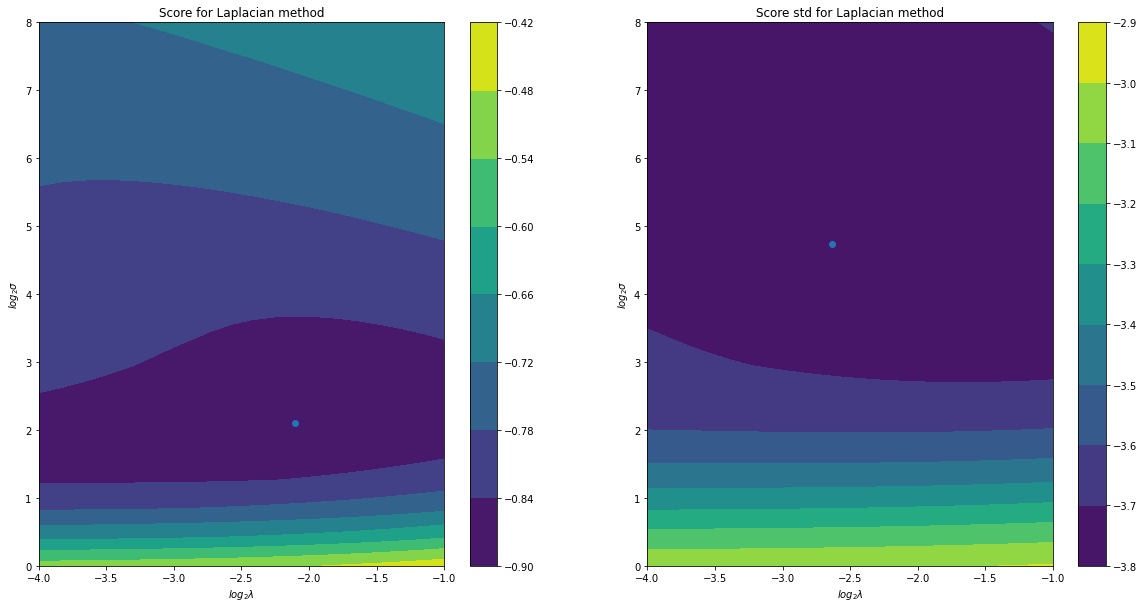

In [20]:
lv3,sv3=np.meshgrid(lmbd,sgm)

fig, ax = plt.subplots(1,2, figsize=(20,10))

cm0 = ax[0].contourf(lv3,sv3, np.log2(np.abs(score_lap)))
ax[0].scatter(-2.105,2.105)
ax[0].set_xlabel('$log_2\lambda$')
ax[0].set_ylabel('$log_2\sigma$')
ax[0].set_title('Score for Laplacian method')
fig.colorbar(cm0, ax=ax[0])


cm1 = ax[1].contourf(lv3, sv3, np.log2(np.abs(score_std_lap)))
ax[1].scatter(-2.632,4.737)
ax[1].set_xlabel('$log_2\lambda$')
ax[1].set_ylabel('$log_2\sigma$')
ax[1].set_title('Score std for Laplacian method')
fig.colorbar(cm1, ax=ax[1])

We then choose $\sigma = 2^{2.105}$, and $\lambda = 2^{-2.105}$ to obtain the best fit. 

Moving on to find the train and test MSEs:

In [29]:
KRR_CV_lap=sklearn.kernel_ridge.KernelRidge(kernel='laplacian')
KRR_CV_lap.gamma=1/(2**2.105)
KRR_CV_lap.alpha=2**-2.105

KRR_CV_lap.fit(X_train,Y_train)

p3_train=KRR_CV_lap.predict(X_train)
p3_test=KRR_CV_lap.predict(X_test)

mse_train=1/len(p3_train)*np.linalg.norm(p3_train-Y_train)**2 
mse_test=1/len(p3_test)*np.linalg.norm(p3_test-Y_test)**2 

print(f'The train MSE for Laplacian kernel is found to be {mse_train}, and the test MSE being {mse_test}')

The train MSE for Laplacian kernel is found to be 0.0578849428426452, and the test MSE being 0.5894883449952983


### Here we see that the two Kernel Ridge Regression methods give smaller MSEs than the linear regression does. Based on the results, the Laplacian kernel method definitely fits our data the best. 

### The Laplacian method produces pretty small MSE for train data set $\approx 0.058$, but comparably high test MSE $\approx 0.589$，which might be over-fitting.  

# Task 3
> Prediction on new batch

In [30]:
batch=np.loadtxt("/content/drive/MyDrive/Colab Notebooks/amath 582 lecture notes/reports /3/wine_new_batch.csv",delimiter=",")
batch_N=batch.shape[0]

# first normalize the new batch data using the previous 
batch_normal=(batch-np.matlib.repmat(train_mean[:11],batch_N,1))/np.matlib.repmat(train_std[:11],batch_N,1)

In [44]:
# predict the scores 
p1=reg.predict(batch_normal)
p2=KRR_CV_rbf.predict(batch_normal)
p3=KRR_CV_lap.predict(batch_normal)

# denormalize and recenter them back, using the normalization coefficients same as normalizing train data set
print(np.round(p1*train_std[11]+train_mean[11],4),sep='  ')
print(np.round(p2*train_std[11]+train_mean[11],4),sep='  ')
print(np.round(p3*train_std[11]+train_mean[11],4),sep='  ')

[6.0047 5.2877 5.5636 6.067  5.9425]
[5.976  5.4329 5.3277 6.1057 6.032 ]
[6.0471 5.475  5.624  5.9732 6.0072]
